In [1]:
! wget https://tanzil.net/trans/en.ahmedali

--2022-06-03 07:43:42--  https://tanzil.net/trans/en.ahmedali
Resolving tanzil.net (tanzil.net)... 209.95.51.187, 136.243.149.84
Connecting to tanzil.net (tanzil.net)|209.95.51.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘en.ahmedali’

en.ahmedali             [ <=>                ] 806.33K  --.-KB/s    in 0.09s   

2022-06-03 07:43:42 (8.33 MB/s) - ‘en.ahmedali’ saved [825681]



In [8]:
with open('en.ahmedali') as f:
    lines = f.readlines()

In [10]:
import pandas as pd
sura, aya, text = [], [], []
for line in lines:
    temp = line.split('|')
    if len(temp)==3:
      sura.append(int(temp[0]))
      aya.append(int(temp[1]))
      text.append(temp[2])
df = pd.DataFrame()
df['sura'] = sura
df['aya'] = aya
df['text'] = text
df

,sura,aya,text
0,1,1,"In the name of Allah, most benevolent, ever-me..."
1,1,2,"ALL PRAISE BE to Allah, Lord of all the worlds,\n"
2,1,3,"Most beneficent, ever-merciful,\n"
3,1,4,King of the Day of Judgement.\n
4,1,5,"You alone we worship, and to You alone turn fo..."
...,...,...,...
6231,114,2,"The King of men,\n"
6232,114,3,"The God of men,\n"
6233,114,4,From the evil of him who breathes temptations ...
6234,114,5,Who suggests evil thoughts to the hearts of me...


In [11]:
import torch
from torch import nn
import torch.optim as optim

import re
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [12]:
def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('\n', '')
    text = text.replace(':', ' <COLON> ')
    words = text.split()

    return words

In [13]:
# get list of words
words = []
for i in range(len(df.text)):
    words = words + preprocess(df.text[i])
print(words[:30])

['in', 'the', 'name', 'of', 'allah', '<COMMA>', 'most', 'benevolent', '<COMMA>', 'ever-merciful', '<PERIOD>', 'all', 'praise', 'be', 'to', 'allah', '<COMMA>', 'lord', 'of', 'all', 'the', 'worlds', '<COMMA>', 'most', 'beneficent', '<COMMA>', 'ever-merciful', '<COMMA>', 'king', 'of']


In [14]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 175032
Unique words: 6782


In [15]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [16]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[11, 1, 321, 4, 1973, 0, 187, 1177, 0, 1019, 2, 55, 362, 26, 6, 1973, 0, 35, 4, 55, 1, 376, 0, 187, 2943, 0, 1019, 0, 765, 4]


In [17]:
threshold = 1e-5
word_counts = Counter(int_words)

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}

# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[1973, 1019, 35, 2943, 1019, 765, 58, 35, 416, 866, 913, 914, 766, 324, 2944, 12, 363, 74, 180, 72, 6, 493, 9, 195, 1020, 55, 1021, 148, 2945, 3973]


In [18]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [19]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=2)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [4, 6]


In [20]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [21]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 3]
y
 [1, 2, 3, 0, 2, 3, 1, 3, 0, 1, 2]


In [22]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

In [23]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        # define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        # Initialize both embedding tables with uniform distribution
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        
    def forward_input(self, input_words):
        # return input vector embeddings

        return self.in_embed(input_words)
    
    def forward_output(self, output_words):
        # return output vector embeddings

        return self.out_embed(output_words)
    
    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        
        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)
        
        ## TODO: get the noise embeddings
        # reshape the embeddings so that they have dims (batch_size, n_samples, n_embed)
        noise_words = self.out_embed(noise_words)
        noise_words = noise_words.view(batch_size, n_samples, self.n_embed)
        
        return noise_words

In [24]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        batch_size, embed_size = input_vectors.shape
        
        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        
        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        # bmm = batch matrix multiplication
        # correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        # incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # negate and sum correct and noisy log-sigmoid losses
        # return average batch loss
        return -(out_loss + noise_loss).mean()

In [25]:
# freqs

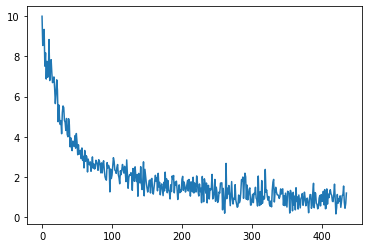

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
# Using word frequencies calculated earlier in the notebook
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# instantiating the model
embedding_dim = 100
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 100
steps = 0
epochs = 20
loss_list = []

# train for some number of epochs
for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 10):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)

        
        
        # input, outpt, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 5)

        
        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            loss_list.append(loss.item())
            # print("Epoch: {}/{}".format(e+1, epochs))
            # print("Loss: ", loss.item()) # avg batch loss at this point in training
            # valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device, valid_size=2)
            # _, closest_idxs = valid_similarities.topk(6)

            # valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            # for ii, valid_idx in enumerate(valid_examples):
            #     closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
            #     print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            
            # print("...\n")
plt.plot(loss_list)

In [27]:
model.forward_input(torch.tensor(vocab_to_int["mothers"], device='cuda'))

tensor([ 0.0310, -0.0695,  1.2934, -1.2722,  0.8562,  0.0624,  0.4001,  0.2475,
        -0.1739,  0.3394, -0.2248,  0.8103,  0.2845, -0.5365,  0.4851,  0.4852,
        -0.3193,  0.2689,  0.4597, -0.6510,  0.2401, -0.1139, -0.1888,  0.4137,
        -0.5824,  0.4342, -0.4543, -0.3339,  0.4290, -0.1358,  0.6741, -0.2944,
        -0.4499,  0.4640, -0.0046,  0.7610,  0.4096,  0.2510,  0.4608,  1.1847,
         0.1049,  0.3246, -0.3472, -0.4169,  0.2438, -1.0959, -0.6745,  0.2141,
        -0.5348, -0.8630,  0.0877,  0.8143,  0.1829,  0.3622,  0.9247,  2.1238,
         0.1531,  1.1704,  1.1729, -0.4699,  0.2394, -0.0466,  1.0105, -0.2438,
         0.5244,  0.4583,  0.4226, -1.0771, -0.2349,  0.5683, -0.4145,  0.9681,
        -1.1919,  0.3334, -0.8677,  0.4868, -0.3084, -0.3534,  0.4405,  0.0200,
         0.6550, -0.5263,  0.4180, -1.6023,  0.2207,  0.5728, -1.3628,  0.4845,
        -0.1564, -0.6122,  0.6942,  1.0083,  0.4495,  1.0087,  0.1370, -1.0232,
         0.6172, -0.2136, -0.6705,  0.79

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
torch.save(model, '/content/drive/MyDrive/datasets/Quran_en.pt')

In [30]:
model_loaded = torch.load('/content/drive/MyDrive/datasets/Quran_en.pt')

In [31]:
model_loaded.forward_input(torch.tensor(vocab_to_int["mothers"], device='cuda'))

tensor([ 0.0310, -0.0695,  1.2934, -1.2722,  0.8562,  0.0624,  0.4001,  0.2475,
        -0.1739,  0.3394, -0.2248,  0.8103,  0.2845, -0.5365,  0.4851,  0.4852,
        -0.3193,  0.2689,  0.4597, -0.6510,  0.2401, -0.1139, -0.1888,  0.4137,
        -0.5824,  0.4342, -0.4543, -0.3339,  0.4290, -0.1358,  0.6741, -0.2944,
        -0.4499,  0.4640, -0.0046,  0.7610,  0.4096,  0.2510,  0.4608,  1.1847,
         0.1049,  0.3246, -0.3472, -0.4169,  0.2438, -1.0959, -0.6745,  0.2141,
        -0.5348, -0.8630,  0.0877,  0.8143,  0.1829,  0.3622,  0.9247,  2.1238,
         0.1531,  1.1704,  1.1729, -0.4699,  0.2394, -0.0466,  1.0105, -0.2438,
         0.5244,  0.4583,  0.4226, -1.0771, -0.2349,  0.5683, -0.4145,  0.9681,
        -1.1919,  0.3334, -0.8677,  0.4868, -0.3084, -0.3534,  0.4405,  0.0200,
         0.6550, -0.5263,  0.4180, -1.6023,  0.2207,  0.5728, -1.3628,  0.4845,
        -0.1564, -0.6122,  0.6942,  1.0083,  0.4495,  1.0087,  0.1370, -1.0232,
         0.6172, -0.2136, -0.6705,  0.79

In [32]:
aya_embeddings = []
for k in range(len(df)):
    aya_embeddings.append(torch.mean(model_loaded.forward_input(torch.tensor([vocab_to_int[i] for i in preprocess(df.text[k])],
                                                                             device='cuda')), axis = 0).cpu().data.numpy())

In [33]:
embed_df = pd.DataFrame(aya_embeddings)
embed_df['sura'] = df['sura']
embed_df['aya'] = df['aya']
embed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,sura,aya
0,0.130459,-0.170920,-0.130430,-0.425366,0.263938,-0.201712,-0.401716,-0.177249,-0.301538,0.023005,...,0.043766,-0.082393,-0.055821,-0.447854,0.080386,-0.177847,-0.070858,0.376248,1,1
1,-0.137422,0.188611,-0.318364,-0.265647,0.076292,-0.156067,-0.147548,-0.022625,-0.183700,0.040179,...,0.022016,-0.072181,0.030498,-0.300821,0.188728,-0.014946,-0.022813,0.142978,1,2
2,-0.105227,-0.367590,0.057834,-0.623360,0.127633,-0.038408,-0.425345,-0.320201,-0.604526,-0.219789,...,-0.340051,-0.145041,-0.165572,-0.362329,-0.119050,-0.301679,0.071205,0.355422,1,3
3,-0.126925,0.020166,0.100932,-0.464344,0.496763,-0.215234,-0.526151,0.088354,-0.222541,0.359380,...,-0.196931,-0.343176,-0.005231,-0.042328,-0.142382,-0.003090,-0.035455,0.143022,1,4
4,-0.060498,0.123393,-0.069733,-0.197850,0.097257,-0.048006,-0.041843,-0.272861,-0.017689,0.029316,...,0.123482,-0.000749,-0.020878,-0.352778,-0.044268,-0.035371,-0.078913,0.105660,1,5


In [34]:
embed_df.to_csv('/content/drive/MyDrive/datasets/Quran_en_vector.csv')